# Agrupación de Direcciones por Cercanía usando Clustering Jerárquico

Este notebook realiza una agrupación de direcciones a partir de sus coordenadas geográficas (Latitud, Longitud) utilizando el algoritmo de **Agglomerative Clustering**. El objetivo es distribuir las direcciones en grupos de proximidad, con un **máximo de 15 direcciones por grupo**, manteniendo la coherencia espacial.

In [44]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import folium
import random

## Paso 1: Cargar los datos de direcciones con coordenadas

In [45]:
# Cargar archivo con coordenadas previamente obtenidas
data = pd.read_excel('output_file_with_coordinates.xlsx')

## Paso 2: Escalado de coordenadas geográficas

In [46]:
# Escalar coordenadas para mejorar el agrupamiento
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(data[['Latitud', 'Longitud']])

## Paso 3: Agrupamiento inicial con Agglomerative Clustering

In [47]:
max_grupos = 60
clustering = AgglomerativeClustering(n_clusters=max_grupos, linkage='ward')
data['Grupo_Temporal'] = clustering.fit_predict(coords_scaled)

## Paso 4: División de grupos con más de 15 direcciones por distancia al centro

In [48]:
centro_valledupar = [10.4631, -73.2532]
max_direcciones_por_grupo = 15
grupo_id = 0
final_grupos = []

for grupo in data['Grupo_Temporal'].unique():
    subgrupo = data[data['Grupo_Temporal'] == grupo].copy()
    subgrupo['DistanciaCentro'] = np.sqrt(
        (subgrupo['Latitud'] - centro_valledupar[0])**2 +
        (subgrupo['Longitud'] - centro_valledupar[1])**2
    )
    subgrupo = subgrupo.sort_values('DistanciaCentro')
    for i in range(0, len(subgrupo), max_direcciones_por_grupo):
        bloque = subgrupo.iloc[i:i + max_direcciones_por_grupo].copy()
        bloque['Grupo_Final'] = grupo_id
        final_grupos.append(bloque)
        grupo_id += 1

data_final = pd.concat(final_grupos)
data_final.drop(columns='DistanciaCentro', inplace=True)

## Detalle de la lógica de división para grupos grandes

Luego del agrupamiento inicial utilizando Agglomerative Clustering (paso 3), observamos que algunos grupos naturales contenían más de 15 direcciones. Sin embargo, como nuestro objetivo era mantener grupos operativos manejables (máximo 15 direcciones), decidimos dividir manualmente estos grupos grandes.

En lugar de forzar al algoritmo a generar un número exacto de grupos desde el principio —lo cual podría resultar en agrupaciones artificiales o poco coherentes geográficamente— aplicamos la siguiente lógica:

1. **Se conservaron los grupos generados naturalmente** por proximidad geográfica.
2. Para cada grupo con más de 15 direcciones:
   - Se calculó la **distancia de cada punto al centro de Valledupar**.
   - Se ordenaron las direcciones **de más cerca a más lejos** del centro.
   - Se dividieron en bloques de 15 direcciones, respetando esa secuencia geográfica.

Este enfoque permite preservar la **coherencia espacial** dentro de los subgrupos y evita crear agrupaciones artificiales que no representen proximidad real entre direcciones. Además, es más flexible y visualmente lógico al momento de asignar tareas operativas, rutas o coberturas zonales.

## Paso 5: Filtrado de grupos con menos de 15 direcciones

In [49]:
# Filtrar grupos pequeños
conteo = data_final['Grupo_Final'].value_counts()
grupos_validos = conteo[conteo >= 15].index
df_filtrado = data_final[data_final['Grupo_Final'].isin(grupos_validos)].copy()

## Paso 6: Visualización de mapas

In [50]:
def mostrar_mapa_todos_los_grupos(df, grupo_col='Grupo_Final'):
    # Crear el mapa centrado en Valledupar
    m = folium.Map(location=[10.4631, -73.2532], zoom_start=13)

    # Crear un color distinto para cada grupo
    grupos_unicos = df[grupo_col].unique()
    colores = {grupo: f'#{random.randint(0, 0xFFFFFF):06x}' for grupo in grupos_unicos}

    # Añadir todos los puntos al mapa
    for _, row in df.iterrows():
        grupo = row[grupo_col]
        color = colores[grupo]
        folium.CircleMarker(
            location=[row['Latitud'], row['Longitud']],
            radius=5,
            popup=f"Grupo: {grupo}<br>Dirección: {row['DIRECCION']}",
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7
        ).add_to(m)

    return m


In [51]:
mostrar_mapa_todos_los_grupos(df_filtrado)


## Paso 7: Visualización de mapas por grupo

In [52]:
def mostrar_mapa_por_grupo(df, grupo_col, grupo_id):
    grupo_df = df[df[grupo_col] == grupo_id]
    m = folium.Map(location=[10.4631, -73.2532], zoom_start=13)
    for _, row in grupo_df.iterrows():
        folium.CircleMarker(
            location=[row['Latitud'], row['Longitud']],
            radius=5,
            popup=f"Grupo: {row[grupo_col]}<br>Dirección: {row['DIRECCION']}",
            color='blue',
            fill=True,
            fill_color='blue'
        ).add_to(m)
    return m

# Ejemplo: mostrar grupo 5
mostrar_mapa_por_grupo(df_filtrado, 'Grupo_Final', 45)

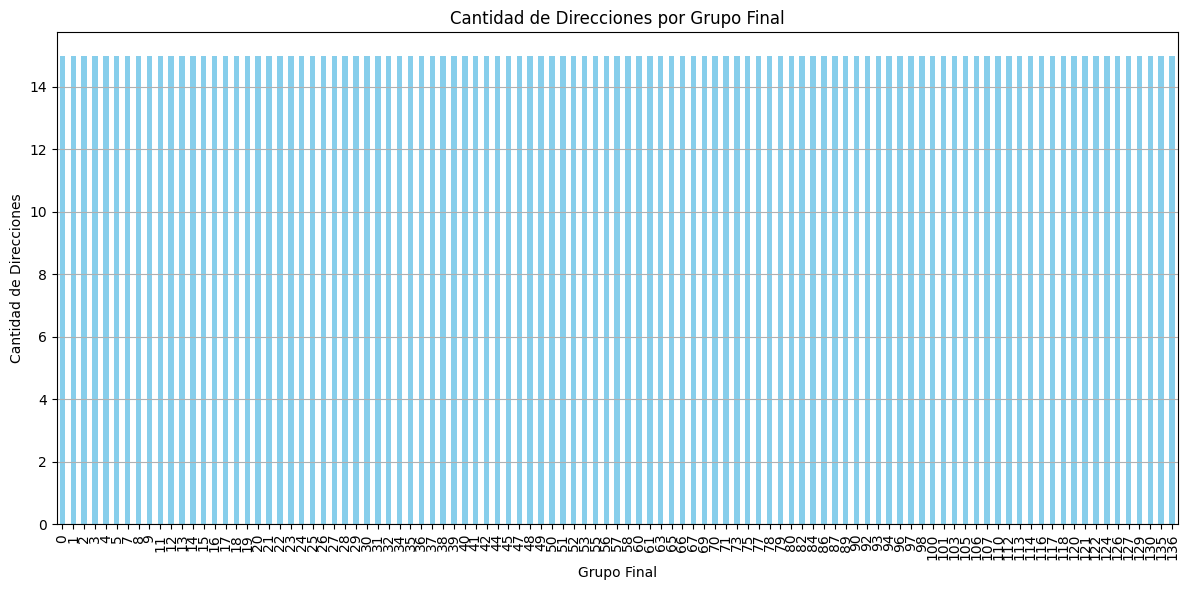

In [53]:
import matplotlib.pyplot as plt

# Contar cuántas direcciones hay en cada grupo
conteo_grupos = df_filtrado['Grupo_Final'].value_counts().sort_index()

# Crear gráfico de barras
plt.figure(figsize=(12, 6))
conteo_grupos.plot(kind='bar', color='skyblue')
plt.title("Cantidad de Direcciones por Grupo Final")
plt.xlabel("Grupo Final")
plt.ylabel("Cantidad de Direcciones")
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [54]:
import plotly.express as px

# Asegúrate de tener 'Grupo_Final', 'Latitud', 'Longitud' y 'DIRECCION' en tu DataFrame
fig = px.scatter_mapbox(
    df_filtrado,
    lat="Latitud",
    lon="Longitud",
    color="Grupo_Final",
    hover_name="DIRECCION",
    zoom=12,
    mapbox_style="carto-positron",  # estilo del mapa
    height=700,
    title="Direcciones agrupadas por proximidad"
)

fig.show()
